In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import pandas as pd
import copy
from tqdm import tqdm
from preprocessing.preprocessing import generate_data, load_data
from model.meta_learner import split_randomly, split_groupIDs, train_models, make_predictions, get_results, kfold_cv, plot_driveIDs, custom_shap_bar_plot, train_models_weighted, export_to_streamlit

/home/stud03/data_science_challenge/Louis/venv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/stud03/data_science_challenge/Louis/venv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for deta

# Create Dataset

In [3]:
# retrieve data from sql database and calculate features. Do this only once
generate_data(path_sql = '/home/stud03/data_science_challenge/data/kit_telematik_dats.sqlite',save_directory = '/home/stud03/data_science_challenge/data/V4')

(3363154, 179)
(3363154, 179)
(2715408, 179)


In [ ]:
# load retrieved data
df = load_data(save_dir = '/home/stud03/data_science_challenge/data/V4', dropna=False, drop_accel_invalid=True, drop_gyro_invalid=True,drop_gps_invalid=True)
df = df.dropna()
df = df.drop(columns=['gps_lat', 'gps_long', 'gps_lat_m', 'gps_long_m']) # drop abs coordinate columns

# Cross Validation - based on groupIDs

In [22]:
# define target variable
target_name = 'target_left'
# target_name = 'target_forward'
results = pd.DataFrame()

# perform cross validation
for test_groupID in tqdm([1,2,3,4,5,6,7,8,9]):

    # get splits
    df_train, df_train_meta, df_test = split_groupIDs(df, test_groupID=test_groupID, generate_nans=True, consider_accel=True, consider_gps=True, consider_gyro=True,  base_learner_size=0.8, exist_prob_train=1, exist_prob_test=1, na_whole_trips=True, chunk_size=30)

    # train models
    model_dict = train_models_weighted(df_train, df_train_meta, target_name)

    # train without weighted models
    # model_dict = train_models(df_train, df_train_meta, target_name)

    # make predictions
    df_y = make_predictions(model_dict, df_test, target_name)

    # get results
    y_train_avg = df_train[target_name].mean()
    df_res = get_results(df_y, df_test, target_name, y_train_avg, meta_only=False)
    df_res = df_res.add_suffix(f'_{test_groupID}')
    results = pd.concat([results, df_res], axis = 1)

100%|██████████| 9/9 [05:54<00:00, 39.40s/it]


In [23]:
# Print results averaged over all folds for each model
print(f'Results for target: {target_name}')
cols = ['gps_model', 'gps_weighted_model', 'gyro_model', 'gyro_weighted_model', 'accel_pred', 'meta_model']
df_results_cv = pd.DataFrame(columns=cols)
for model in cols:
    df_results_cv[model] = results[results.columns[results.columns.str.contains(model)]].mean(axis=1)
df_results_cv

,gps,gyro,accel,meta
r2,0.492000,0.851556,0.929000,0.935000
mae,0.411767,0.213933,0.142178,0.139156
mse,0.474111,0.123556,0.054333,0.046778
mae>2,1.538444,0.521889,0.284556,0.313222
mse>2,2.898444,0.425222,0.167778,0.175444
mae>3,2.149000,0.746667,0.312556,0.440667
mse>3,5.176000,0.811444,0.174444,0.297111
mae>10km/h,0.458333,0.229778,0.151889,0.148444
mse>10km/h,0.537889,0.134333,0.058333,0.050444
max_absolute_diff,1.341556,0.709889,0.394111,0.420333


# Cross Validation - randomly based on driveIDs

In [ ]:
target_name = 'target_left'
# target_name = 'target_forward'
results = kfold_cv(df, target_name, folds=5, generate_nans=False, consider_accel=True, consider_gyro=True, consider_gps=True, base_learner_size=0.8, exist_prob_train=1, exist_prob_test=1, random_state=42, weighted=True, na_whole_trips=True, chunk_size=30)

In [65]:
# Print results averaged over all folds for each model
cols = ['gps_model', 'gps_weighted_model', 'gyro_model', 'gyro_weighted_model', 'accel_pred', 'meta_model']
df_results_cv = pd.DataFrame(columns=cols)
for model in cols:
    df_results_cv[model] = results[results.columns[results.columns.str.contains(model)]].mean(axis=1)
df_results_cv

,gps_model,gps_weighted_model,gyro_model,gyro_weighted_model,accel_pred,meta_model
r2,0.57440,0.28720,0.81720,0.76780,0.8518,0.90440
mae,0.25214,0.33812,0.17794,0.21044,0.1459,0.12958
mse,0.18040,0.30220,0.07780,0.09840,0.0630,0.04100
mae>2,1.39440,0.98100,0.62800,0.51580,0.4672,0.36740
mse>2,2.80720,1.58420,0.63660,0.46220,0.4982,0.27820
mae>3,1.95300,1.30900,0.87320,0.68700,0.5252,0.47200
mse>3,5.11060,2.46280,1.10880,0.78000,0.6682,0.46100
mae>10km/h,0.24960,0.30000,0.18120,0.21160,0.1512,0.13220
mse>10km/h,0.15860,0.18700,0.07500,0.09340,0.0640,0.03980
max_absolute_diff,3.62920,3.73840,2.14760,2.30560,1.7446,1.62980


# Simple train_base/train_meta/test split

In [13]:
# random train test split
target_name = 'target_left'
# target_name = 'target_forward'
results = pd.DataFrame()

# get splits
df_train, df_train_meta, df_test = split_randomly(df, generate_nans=True, consider_accel=True, consider_gyro=True, consider_gps=True, train_size=0.8, base_learner_size=0.8, exist_prob_train=1, exist_prob_test=0.9, na_whole_trips=False, chunk_size=30)

# train models
model_dict = train_models_weighted(df_train, df_train_meta, target_name)

# make predictions
df_y = make_predictions(model_dict, df_test, target_name)

# also return the train test dataframes in a dict
df_y, data_dict = make_predictions(model_dict, df_test, target_name, return_dfs=True)

# get results
y_train_avg = df_train[target_name].mean()
df_results = get_results(df_y, df_test, target_name, y_train_avg, meta_only=False)

,meta_model_pred,accel_pred,gyro_model_pred,gps_model_pred,gps_weighted_model_pred,gyro_weighted_model_pred
r2,0.8130,0.7830,0.3520,0.7020,0.6590,0.2320
mae,0.1756,0.1928,0.3488,0.2253,0.2477,0.4189
mse,0.0760,0.0880,0.2630,0.1210,0.1380,0.3120
mae>2,0.5090,0.4740,1.7350,0.8390,0.6840,1.3530
mse>2,0.7120,0.6950,3.4470,1.1590,0.9170,2.4190
mae>3,0.9920,0.5750,2.6700,1.4510,1.2100,2.1660
mse>3,1.6750,1.1040,7.7890,2.8400,2.2440,5.5670
mae>10km/h,0.1760,0.1970,0.3480,0.2030,0.2250,0.4140
mse>10km/h,0.0740,0.0880,0.2580,0.0870,0.1040,0.3040
max_absolute_diff,0.4460,0.4470,0.9210,0.6370,0.6870,1.0520


# Save predictions

In [11]:
export_to_streamlit(df_y, df_test, save_path='/home/stud03/data_science_challenge/Louis/files_huk/models/results/whole_trips_left_90.pkl')

file saved to /home/stud03/data_science_challenge/Louis/files_huk/results/short_trips_left.pkl


# Predictions on trips with Sensor failures (invalid tags)

In [25]:
df_inc = load_data(save_dir = '/home/stud03/data_science_challenge/data/V3', dropna=False, drop_accel_invalid=False, drop_gps_invalid=False, drop_gyro_invalid=False)

# only keep driveID which have invalid entries
corrupt_drive_ids_accel = set(df_inc[df_inc['accel_valid'] == 0]['driveID'])
corrupt_drive_ids_gyro = set(df_inc[df_inc['gyro_valid'] == 0]['driveID'])
corrupt_drive_ids_gps = set(df_inc[df_inc['gps_valid'] == 0]['driveID'])
df_inc = df_inc[df_inc['driveID'].isin(corrupt_drive_ids_gps.union(corrupt_drive_ids_gyro, corrupt_drive_ids_gps))]
print(df_inc.shape)

df_inc = df_inc.drop(columns=['gps_lat', 'gps_long', 'gps_lat_m', 'gps_long_m'])

2023-08-07 08:38:33.677 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-08-07 08:38:33.680 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


(1253578, 113)


In [92]:
# missing data
df_inc[['gps_valid', 'gyro_valid', 'accel_valid']].sum() / len(df_inc)

gps_valid      0.974849
gyro_valid     0.810127
accel_valid    0.810127
dtype: float64

In [ ]:
# make predictions
df_y = make_predictions(model_dict, df_inc, target_name, return_dfs=True)

# is needed to calculate the out of sample r^2. its the average accel in the training set
y_train_avg_forward = 0.0525226
y_train_avg_forward = 0.0545226

df_results = get_results(df_y, df_test, target_name, y_train_avg_forward, meta_only=False)

In [96]:
# results forward
df_results

,meta_model_pred,accel_pred,gyro_model_pred,gps_model_pred,gps_weighted_model_pred,gyro_weighted_model_pred
r2,0.8230,0.6940,0.2420,0.709,0.6130,0.1030
mae,0.1892,0.2285,0.3918,0.236,0.2811,0.4613
mse,0.0780,0.1350,0.3340,0.128,0.1710,0.3960
mae>2,0.4180,0.6700,1.8750,0.775,0.5970,1.6070
mse>2,0.3770,1.2220,4.0290,0.968,0.6800,3.3190
mae>3,1.0170,1.0170,2.8910,1.465,1.1740,2.5680
mse>3,1.4890,2.8130,9.1250,2.876,2.1970,7.6770
mae>10km/h,0.2010,0.2500,0.4160,0.241,0.2780,0.4660
mse>10km/h,0.0810,0.1460,0.3560,0.121,0.1550,0.4010
max_absolute_diff,0.7210,0.9130,1.5080,1.012,1.1630,1.5840


# Predictions on whole Trips

In [3]:
df_trips = pd.read_pickle('/home/stud03/data_science_challenge/data/whole_trips/1hz_trips.pkl')

In [4]:
df_trips = df_trips.drop(columns=['gps_lat', 'gps_long', 'gps_lat_m', 'gps_long_m'])

In [5]:
df_trips[['gps_valid', 'gyro_valid', 'accel_valid']].sum() / len(df_trips)

gps_valid      0.977889
gyro_valid     0.993287
accel_valid    0.993287
dtype: float64

In [12]:
# get it to the same amount of features as df
df = df.drop(columns='groupID')
df_trips = df_trips[df.columns]

In [11]:
df_trips = df_trips.drop(columns=df_trips.columns[df_trips.columns.str.contains('valid_')])

In [97]:
# random train test split
target_name = 'target_left'
results = pd.DataFrame()

# get splits
df_train, df_train_meta, df_test = split_randomly(df_trips, generate_nans=True, consider_accel=True, consider_gyro=True, consider_gps=True, train_size=0.8, base_learner_size=0.8, exist_prob_train=0.9, exist_prob_test=0.9, na_whole_trips=False, chunk_size=60)

# train models
model_dict = train_models_weighted(df_train, df_train_meta, target_name)

In [98]:
# mit left
# make predictions
df_y = make_predictions(model_dict, df_test, target_name, return_dfs=False)

# get results
y_train_avg = df_train[target_name].mean()
df_results = get_results(df_y, df_test, target_name, y_train_avg, meta_only=False)
df_results

,meta_model_pred,accel_pred,gyro_model_pred,gps_model_pred,gps_weighted_model_pred,gyro_weighted_model_pred
r2,0.8740,0.8200,0.7770,0.5540,0.5060,0.7350
mae,0.1425,0.1524,0.1834,0.2596,0.3062,0.2227
mse,0.0580,0.0830,0.1030,0.2060,0.2290,0.1230
mae>2,0.4300,0.5450,0.7310,1.4260,1.1860,0.6170
mse>2,0.3920,0.8140,1.0840,2.7640,2.1080,0.8720
mae>3,0.5130,0.6250,1.0940,1.6850,1.3490,0.8880
mse>3,0.5240,1.3140,2.0790,3.9050,2.7920,1.6230
mae>10km/h,0.1490,0.1630,0.1910,0.2650,0.3030,0.2250
mse>10km/h,0.0610,0.0880,0.1030,0.1930,0.2060,0.1200
max_absolute_diff,2.0700,2.3600,2.8090,3.4620,3.4090,2.8940


In [99]:
export_to_streamlit(df_y, df_test, save_path='/home/stud03/data_science_challenge/Louis/files_huk/models/results/whole_trips_left_90.pkl')

file saved to /home/stud03/data_science_challenge/Louis/files_huk/models/results/whole_trips_90_left.pkl


# SHAP Values

In [ ]:
model = model_dict['meta_model']

# hier den entsprechenden datensatz aus data_dict auswählen
#X_test =

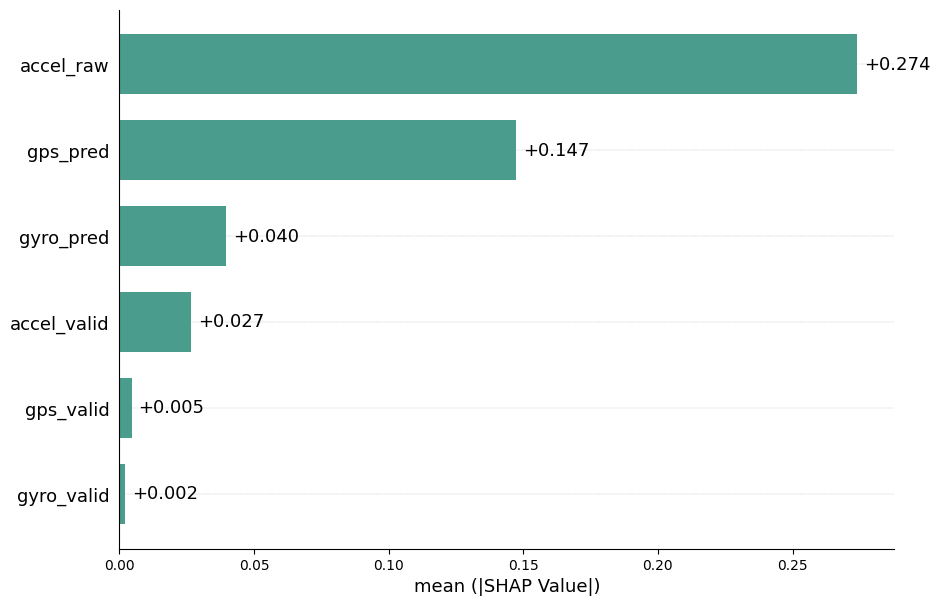

In [95]:
# Shap Explainer (Forward)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
custom_shap_bar_plot(copy.deepcopy(shap_values.values), X_test.columns, max_display=10, fig_size=(10, 7), color='#4A9C8C', filesave=f'/home/stud03/data_science_challenge/Louis/files_huk/plots/{target_name}_shap_meta_on_invalids.png')

In [ ]:
# Shap Explainer (Left)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
custom_shap_bar_plot(copy.deepcopy(shap_values.values), X_test.columns, max_display=10, fig_size=(10, 7), color='#4A9C8C', filesave=f'/home/stud03/data_science_challenge/Louis/files_huk/plots/{target_name}_shap_meta_on_invalids.png')

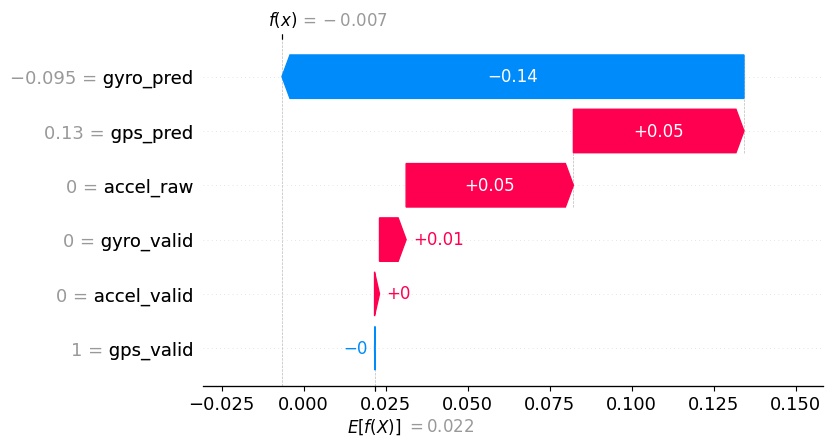

In [87]:
shap.plots.waterfall(shap_values[6229])